In [ ]:
import torch
import torch.nn as nn
from typing import List
from data.budworm import simulate_trials, budworm_steady_states
from stabnode.schedulers import ExpLossTimeDecayScheduler
import matplotlib.pyplot as plt
from stabnode.utils import set_global_seed
plt.style.use("ggplot")

import numpy as np

device = 'cpu'

set_global_seed(1234)

In [134]:
x_lin = np.linspace(0.1,10,20)
x_lin

array([ 0.1       ,  0.62105263,  1.14210526,  1.66315789,  2.18421053,
        2.70526316,  3.22631579,  3.74736842,  4.26842105,  4.78947368,
        5.31052632,  5.83157895,  6.35263158,  6.87368421,  7.39473684,
        7.91578947,  8.43684211,  8.95789474,  9.47894737, 10.        ])

In [135]:
k = 8.5
r=0.56


xs = []
ts = []

for x0 in x_lin:
    trial = simulate_trials(
        [k],
        x0,
        dt=0.2,
        r=0.56,
        eps=1e-3,
        buffer=1e-1,
        t_max=400,
        n_points=501,
        show_progress=False,
    )
    if len(trial.t_vals[0]) == 1:
        continue
    xs.append(trial.x_vals[0])
    ts.append(trial.t_vals[0])


In [136]:
# t = bw_trials.t_vals[0]
# x = bw_trials.x_vals[0]
# x_steady = bw_trials.x_stars[0]

In [137]:
x_steady_states = budworm_steady_states(k,r)

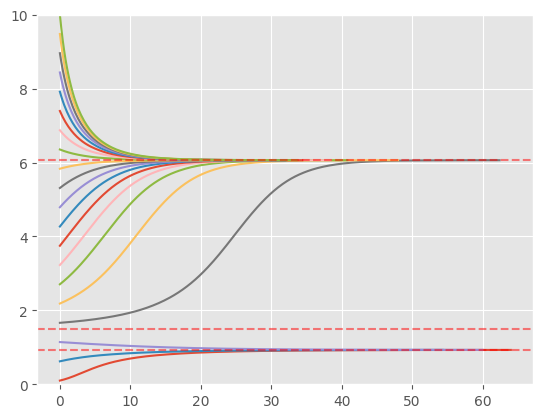

In [138]:
for t,x in zip(ts,xs):
    plt.plot(t,x)
# plt.axhline(x_steady, c='black', linestyle='--', alpha=0.5)
for x_steady in x_steady_states:
    plt.axhline(x_steady,c='red', linestyle='--',alpha=0.5)
plt.ylim(0,10)
plt.show()

In [139]:
from data.budworm import g_true, f_true

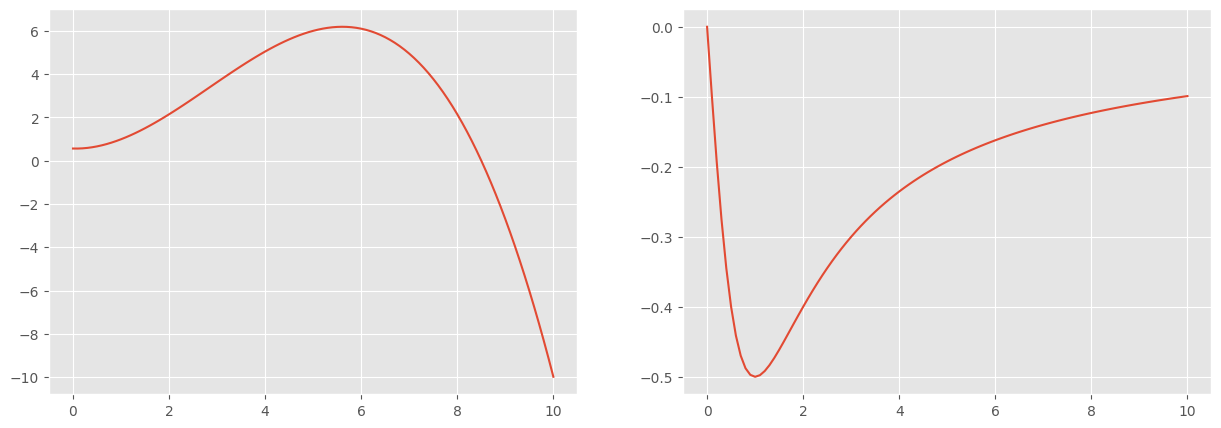

(6.1826635294117676, -9.981176470588235)

In [140]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
x_lin = np.linspace(0,10,101)
g_true_arr = g_true(x_lin,k=k,r=r)
f_true_arr = f_true(x_lin)

ax1.plot(x_lin,g_true_arr)
ax2.plot(x_lin, f_true_arr)
plt.show()

g_true_arr.max(), g_true_arr.min()

In [141]:
xs_torch = [torch.tensor(
    xi, dtype=torch.float32,device=device
) for xi in xs]
ts_torch = [torch.tensor(
    ti, dtype=torch.float32,device=device
) for ti in ts]

ks_torch =[torch.tensor(
   k, dtype=torch.float32,device=device
) for _ in xs]

In [142]:
class TrialsDataset(torch.utils.data.Dataset):
    def __init__(self, x_trials: List, t_trials: List, k_trials: List):
        self.x_trials = x_trials
        self.t_trials = t_trials
        self.k_trials = k_trials

    def __len__(self):
        return len(self.x_trials)

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self):
            raise IndexError(
                f"Index {idx} is out of bounds of dataset size: {len(self)}."
            )

        Xi = self.x_trials[idx]
        ti = self.t_trials[idx]
        x0 = Xi[0]
        ki = self.k_trials[idx]

        return Xi, ti, x0, ki

In [145]:
train_dataset = TrialsDataset(xs_torch, ts_torch, ks_torch)
train_loader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=1, num_workers=0
)

In [146]:
from stabnode.node import (
    FeluSigmoidMLP, 
    GeluSigmoidMLPfeaturized, 
    StabNODE,
    model_trainer,
)

In [147]:
f = FeluSigmoidMLP(
    dims=[1, 10, 10, 1],
    activation=nn.SiLU(),
    lower_bound=-0.5,
    upper_bound=-0.1,
)

g = GeluSigmoidMLPfeaturized(
    dims=[6, 10, 10, 1],
    activation=nn.SiLU(),
    lower_bound=-10,
    upper_bound=7,
    freq_sample_step=1,
    feat_lower_bound=0,
    feat_upper_bound=1,
)

model = StabNODE(f, g).to(device)

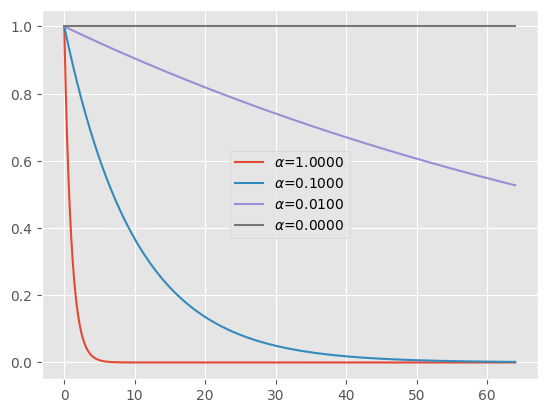

In [148]:
alphas = [1,0.1,0.01, 0]
for alpha in alphas:
    plt.plot(ts[0],np.exp(-alpha*ts[0]),label=rf"$\alpha$={alpha:.4f}")
plt.legend()
plt.show()

In [149]:
lr = 1e-2
epochs=500
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters()) + list(g.parameters()), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="min", factor=0.1, patience=10
)

model, log_history = model_trainer(
    model=model,
    opt=opt,
    loss_criteria=loss_criteria,
    train_loader=train_loader,
    n_epochs=epochs,
    control=None,
    min_improvement=1e-6,
    patience=300,
    solve_method="tsit5",
    save_folder=None,
    show_progress=True,
    scheduler=scheduler,
    print_every=10,
    _precision=15,
    train_dyn=True,
    decay_scheduler=None,
    decay_val=alphas[0],
)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Loss: 0.171998750884086. time = 58.569874048233032s. lr = 0.010000000000000. alpha = 1.000000000000000
Epoch 1: Loss: 0.242979447667797. time = 56.707987785339355s. lr = 0.010000000000000. alpha = 1.000000000000000
Epoch 2: Loss: 0.237107107726236. time = 59.930600881576538s. lr = 0.010000000000000. alpha = 1.000000000000000
Epoch 3: Loss: 0.218117534648627. time = 59.253825187683105s. lr = 0.010000000000000. alpha = 1.000000000000000
Epoch 4: Loss: 0.216711815136174. time = 60.366145610809326s. lr = 0.010000000000000. alpha = 1.000000000000000
Epoch 5: Loss: 0.279662031369905. time = 59.063470125198364s. lr = 0.010000000000000. alpha = 1.000000000000000
Epoch 10: Loss: 0.269258034725984. time = 59.630965948104858s. lr = 0.010000000000000. alpha = 1.000000000000000
Epoch 20: Loss: 0.166099038595955. time = 59.874690771102905s. lr = 0.001000000000000. alpha = 1.000000000000000
Epoch 30: Loss: 0.136041561840102. time = 63.143767833709717s. lr = 0.001000000000000. alpha = 1.00000

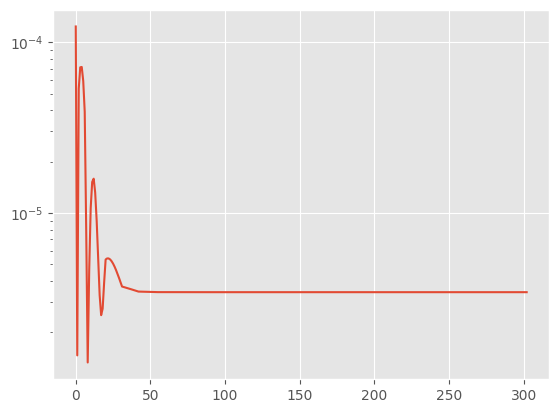

In [97]:
plt.plot(log_history['losses'])
plt.yscale("log")
plt.show()

In [98]:
f_eval  = f.eval()
g_eval = g.eval()
model_eval = StabNODE(f_eval, g_eval)
model_eval.eval()

StabNODE(
  (f): FeluSigmoidMLP(
    (activation): SiLU()
    (network): MLP(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Linear(in_features=1, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
    )
  )
  (g): GeluSigmoidMLPfeaturized(
    (activation): SiLU()
    (network): MLP(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Linear(in_features=6, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
    )
  )
)

In [100]:
with torch.no_grad():
    x_lin_torch = torch.tensor(x_lin, dtype=torch.float32)
    f_pred = [f_eval(xi.reshape(-1,1)).reshape(-1) for xi in x_lin_torch]
    f_pred = torch.cat(f_pred)

    k_torch = torch.tensor(k,dtype=torch.float32).reshape(-1,1)
    g_pred =torch.cat([g_eval(torch.tensor([[xi]],dtype=torch.float32),k_torch).reshape(-1) for xi in x_lin_torch])

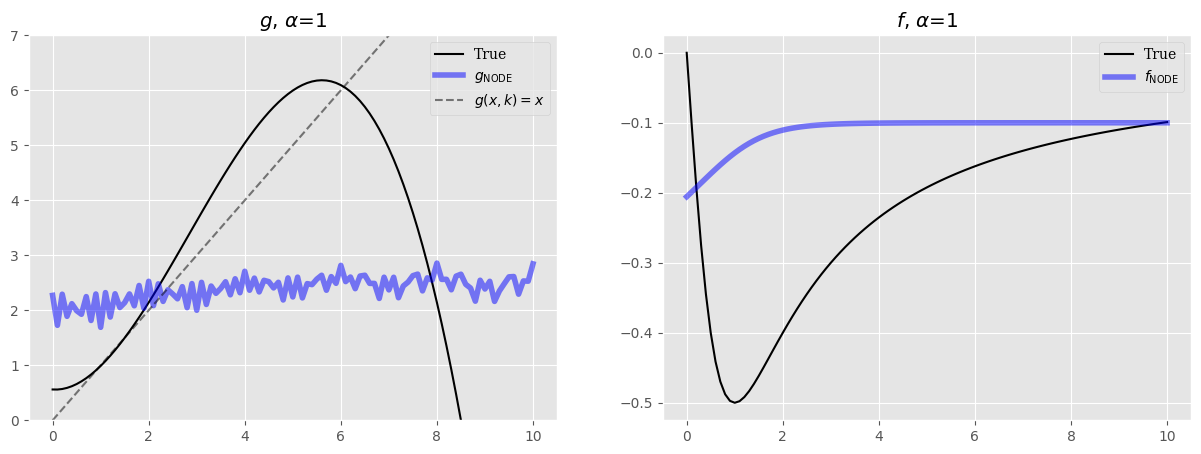

In [119]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(x_lin, g_true_arr, c='black', label='True')
ax1.plot(x_lin, g_pred, c='blue', alpha=0.5, lw=4, label=r"$g_{\text{NODE}}$")
ax1.plot(x_lin,x_lin,c='black', linestyle='--',alpha=0.5, label=r"$g(x,k)=x$")
ax1.set_ylim(0,7)

ax1.set_title(rf"$g$, $\alpha$={alphas[0]}")
ax1.legend(prop={'family':'serif'})

ax2.plot(x_lin, f_true_arr,c='black', label="True")
ax2.plot(x_lin, f_pred,c='blue', alpha=0.5, lw=4, label=r"$f_{\text{NODE}}$")
ax2.set_title(rf"$f$, $\alpha$={alphas[0]}")
ax2.legend(prop={'family':'serif'})

plt.show()